SBI on SDE data with dynamical noise 0.1 when only data for $v$ is considered available (used for fitting), using 100k simulations.

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np

import re
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch

import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

from scipy import signal
from scipy.signal import hilbert
from scipy import stats as spstats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW/SBI'

In [6]:
! mkdir -p results

In [7]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

In [8]:
def Montbrio_SDEmodel(params, constants, I_input, dt, ts):
   
    delta, eta, J, sigma  = params[0], params[1], params[2], params[3]
    

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init

        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [9]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

In [10]:
t_init = 0.0
t_final = 100.0
dt = 0.001
sigma = 0.1
I0 = 3.
t_on = 30.
t_off = 60.
v0 = -3.0
r0 = 0.5
ts = np.arange(t_init, t_final, dt)
sim_params={'t_init': t_init, 't_final': t_final, 'dt': dt, 'sigma': sigma,
            'I0': I0, 't_on': t_on, 't_off': t_off, 'r0': r0, 'v0': v0}

In [11]:
delta_true = 0.7
eta_true = -4.6
J_true = 14.5
sigma_true = sigma
params_true = np.array([delta_true, eta_true, J_true, sigma_true])

In [12]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [13]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']
X_obs = np.vstack([v_obs, r_obs])

## Data features

In [14]:
from MPR_NMM_sumstats import calculate_summary_statistics
#args: y, dt, ts, t_on, _off

In [15]:
calculate_summary_statistics_numba = numba.jit(calculate_summary_statistics)

# Noise 0.1, Estimated noise, (v, )

In [17]:
def Montbrio_SDEmodel(params, constants, I_input, dt, ts):
   
    delta, eta, J, sigma  = params[0], params[1], params[2], params[3]
    

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init

        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))

Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    
    return summstats_v

In [16]:
params_true = np.array([delta_true, eta_true, J_true, sigma_true])

In [19]:
prior_min = [0.2, -10., 5., 0.]
prior_max = [5., -3., 20., 1.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [ ]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=100000, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

/tmp/ipykernel_76918/2887490818.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Montbrio_SDEmodel" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
   - Of which 16 did not match due to:
   Overload of function 'setitem': File: <numerous>: Line N/A.
     With argument(s): '(array(float64, 1d, C), int64, array(float64, 1d, C))':
    No match.

During: typing of setitem at /tmp/ipykernel_76918/2887490818.py (21)

File "../../../../../../tmp/ipykernel_76918/2887490818.py", line 21:
<source missing, REPL/exec in use?>

  def Montbrio_SDEmodel(params, constants, I_input, dt, ts):
/tmp/ipykernel_76918/2887490818.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "Montbrio_SDEmodel" failed type infere

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [32]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
obs_summary_stats = v_obs_summary_stats

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [33]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
params_est = np.array(posterior_sample, dtype='float64')

delta_est=params_est[:,0]
eta_est=params_est[:,1]
J_est=params_est[:,2]
sig_est=params_est[:,3]

params_label=np.array(['$\Delta$', '$\eta$', '$J$', '$\sigma$'])

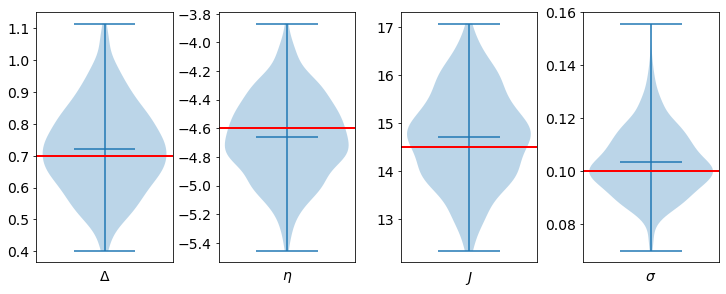

In [35]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est, sig_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=params_true[i], linewidth=2, color='r')
    plt.xticks([])
    plt.yticks(fontsize=14)
    plt.xlabel(params_label[i], fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

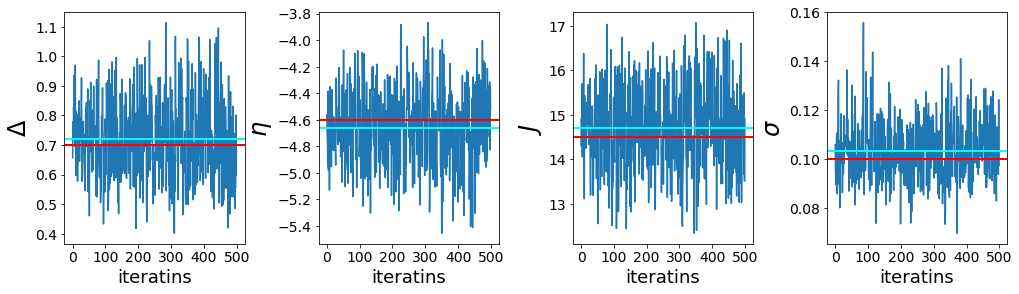

In [36]:
plt.figure(figsize=(14, 4))
for i, variables in enumerate([delta_est, eta_est, J_est, sig_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.plot(variables)
    plt.axhline(y=params_true[i], linewidth=2, color='r')
    plt.axhline(y=variables.mean(), linewidth=2, color='cyan')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xlabel('iteratins', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [63]:
res_dict = {'delta_distrib': list(delta_est), 'eta_distrib': list(eta_est), 
            'J_distrib': list(J_est), 'sigma_distrib': list(sig_est)
            }
json_object = json.dumps(res_dict, indent=4)
with open("results/v_only_sbi_feat_sim_output100k.json", "w") as outfile:
    outfile.write(json_object)

In [64]:
with open("results/v_only_sbi_feat_sim_output100k.json", "r") as readfile:
    sim = json.load(readfile)

In [65]:
theta_posterior = np.vstack([sim['delta_distrib'], sim['eta_distrib'], sim['J_distrib'], sim['sigma_distrib']]).T

In [66]:
from report_metrics import posterior_peaks
var_labels = ['delta', 'eta', 'J', 'sig']
MAP = posterior_peaks(torch.as_tensor(theta_posterior), return_dict=True, 
                      labels=var_labels)
MAP_vals= list(MAP.values())
MAP_vals

[0.706836530140468, -4.711305078195066, 14.75366245970434, 0.09958092685864896]

In [67]:
rmse_prms = RMSE(params_true, MAP_vals)
rmse_prms

0.13854636197129588

In [68]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]
y_fit = Montbrio_SDEmodel(MAP_vals,
                         constants, I_input, dt, ts)

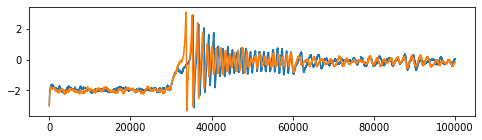

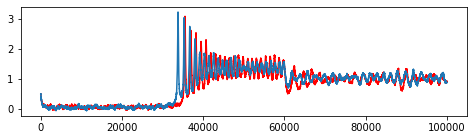

In [69]:
v_sim_est = y_fit[:len(y_fit)//2]
r_sim_est = y_fit[len(y_fit)//2:]

plt.figure(figsize=(8, 2))
plt.plot(v_obs)
plt.plot(v_sim_est)
plt.figure(figsize=(8, 2))
plt.plot(r_obs, 'r')
plt.plot(r_sim_est);

In [70]:
Sim_est = v_sim_est
cost_final = np.sqrt(np.sum((Sim_est - v_obs)**2))
cost_final 

196.55091098767437

In [73]:
for i in range(len(var_labels)) :
    sim[var_labels[i]] = MAP_vals[i]
sim['rmse_prms'] = rmse_prms
sim['v_sim'] = list(v_sim_est)
sim['r_sim'] = list(r_sim_est)
sim['cost'] = cost_final

In [74]:
json_object = json.dumps(sim, indent=4)
with open("results/v_only_sbi_feat_sim_output100k.json", "w") as outfile:
    outfile.write(json_object)